 Notebook color scheme 

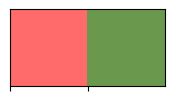

In [1]:
from typing import Any, Optional, Dict, List, Tuple


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import transformers
import lightning.pytorch as pl
import torchmetrics
import albumentations
import os
import wandb
import sys
import json
import gc


from PIL import Image
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import train_test_split, StratifiedKFold

from IPython.display import display_latex, display_markdown
from matplotlib.colors import ListedColormap
from rich.console import Console
from rich.progress import track
from rich.table import Table
from rich import print as rprint

from collections import defaultdict

torch.set_float32_matmul_precision('high')

MY_COLORS = ["#ff6b6b", "#6a994e"]
MY_COLORMAP = ListedColormap(MY_COLORS)

WANDB_CONFIG = {"experiment":"GSoc2023", "_wandb_kernel":"aot"}

rprint("[bold #6a994e] Notebook color scheme [/bold #6a994e]")
sns.palplot(sns.color_palette(MY_COLORS))
plt.show()



In [2]:
api_key = os.environ['WANDB_API_KEY']
!wandb login $api_key

wandb: Appending key for api.wandb.ai to your netrc file: /home/darthvader/.netrc


# Create MetaData

In [3]:
def createMetaData(root_dir: str) -> "pd.DataFrame":
    """
    This function is used to create the metaData for our classfication algorithm.
    
    :param root_dir: the directory where our data is present.
    
    :returns: the processed metaData for our classification algorithm.
    """
    
    metaData = defaultdict(lambda : list())
    for folder in os.listdir(root_dir):
        for img_files in os.listdir(os.path.join(root_dir, folder)):
            metaData['img_path'].append(os.path.join(root_dir, folder, img_files))
            metaData['label'].append(folder)
            
    metaData = pd.DataFrame(metaData)
    metaData = metaData.sample(frac=1, random_state=32)
    return metaData

In [4]:
def print_dataset(data: "pd.DataFrame", n_rows: Optional[int]=5, title: Optional[str]="DataFrame", rule: Optional[bool]=False) -> None:
    """
    An asthetic function to print the dataframe using the rich library.
    
    :param data: the dataframe
    :param n_rows: the number of top-n rows in the dataframe.
    :param title: a title for the dataframe.
    :param rule: whether to add any ruler above the dataframe or not.
    
    :returns: None
    """
    
    table = Table(title=title, caption=f"The following table originally has {data.shape[0]} records and {data.shape[1]} attributes")
    data = data.head(n_rows)
    
    table.add_column("img_path", justify="right", style="#BF00FF", no_wrap=False)
    table.add_column("label", justify="center", style="#E52B50", no_wrap=False)
    
    for row in data.iterrows():
        table.add_row(row[1][0], row[1][1])
        
    console = Console()
    
    if rule:
        console.rule(f"[bold #FFBA00]{title}")
    
    console.print(table)

In [5]:
df = createMetaData("../data/lenses/")
print_dataset(df)

                                     DataFrame                                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃                                                                img_path ┃ label  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ ../data/lenses/no_sub/image_108690015052930553067197496873232013018.jpg │ no_sub │
│    ../data/lenses/sub/image_156201126136719159700605005706933792478.jpg │  sub   │
│    ../data/lenses/sub/image_253190511128682534503157709967780277011.jpg │  sub   │
│ ../data/lenses/no_sub/image_284213815099105864994901790678692515852.jpg │ no_sub │
│ ../data/lenses/no_sub/image_219509025692630031435225868275521690661.jpg │ no_sub │
└─────────────────────────────────────────────────────────────────────────┴────────┘
         The following table originally has 10000 records and 2 attributes          

# Visualize Data

## Target Data Distribution

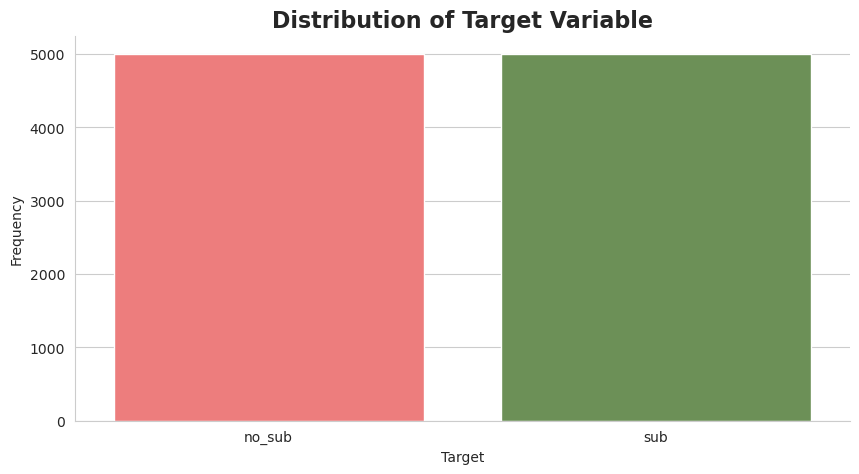

In [6]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
plt.title("Distribution of Target Variable", fontsize=16, weight="bold")
sns.countplot(x="label", data=df, palette=MY_COLORS)
plt.xlabel("Target")
plt.ylabel("Frequency")
sns.despine()
plt.show()

## Sample Images

In [7]:
def view_sample_imgs(data: "pd.DataFrame", target: str, n_samples: Optional[int]=5) -> None:
    """
    This function is used to view sample images in our dataset.
    
    :param data: the dataframe
    :param target: the target variable 
    :param n_samples: number of sample images to view.
    
    :returns None:
    """
    
    data = data.loc[data["label"] == target].sample(n_samples, random_state=32)
    fig, axs = plt.subplots(1, n_samples, figsize=(24, 12))
    axs = axs.flatten()
    
    title_cols = {"no_sub": MY_COLORS[0], "sub": MY_COLORS[1]}
    wandb_imgs = list()
    
    for i in range(n_samples):
        img_fp = data.iloc[i]["img_path"]
        img = Image.open(img_fp)
        
        wandb_imgs.append(wandb.Image(np.array(img)))
        
        img = img.resize((512, 512), resample=Image.Resampling.BILINEAR)
        
        axs[i].set_title(f"{i+1} - {target}", weight="bold", fontsize=12, color=title_cols[target])
        axs[i].imshow(img)
        axs[i].axis('off')
        
        
    plt.tight_layout()
    plt.show()
    
    wandb.log({target: wandb_imgs})

wandb: Currently logged in as: lmorningstar. Use `wandb login --relogin` to force relogin


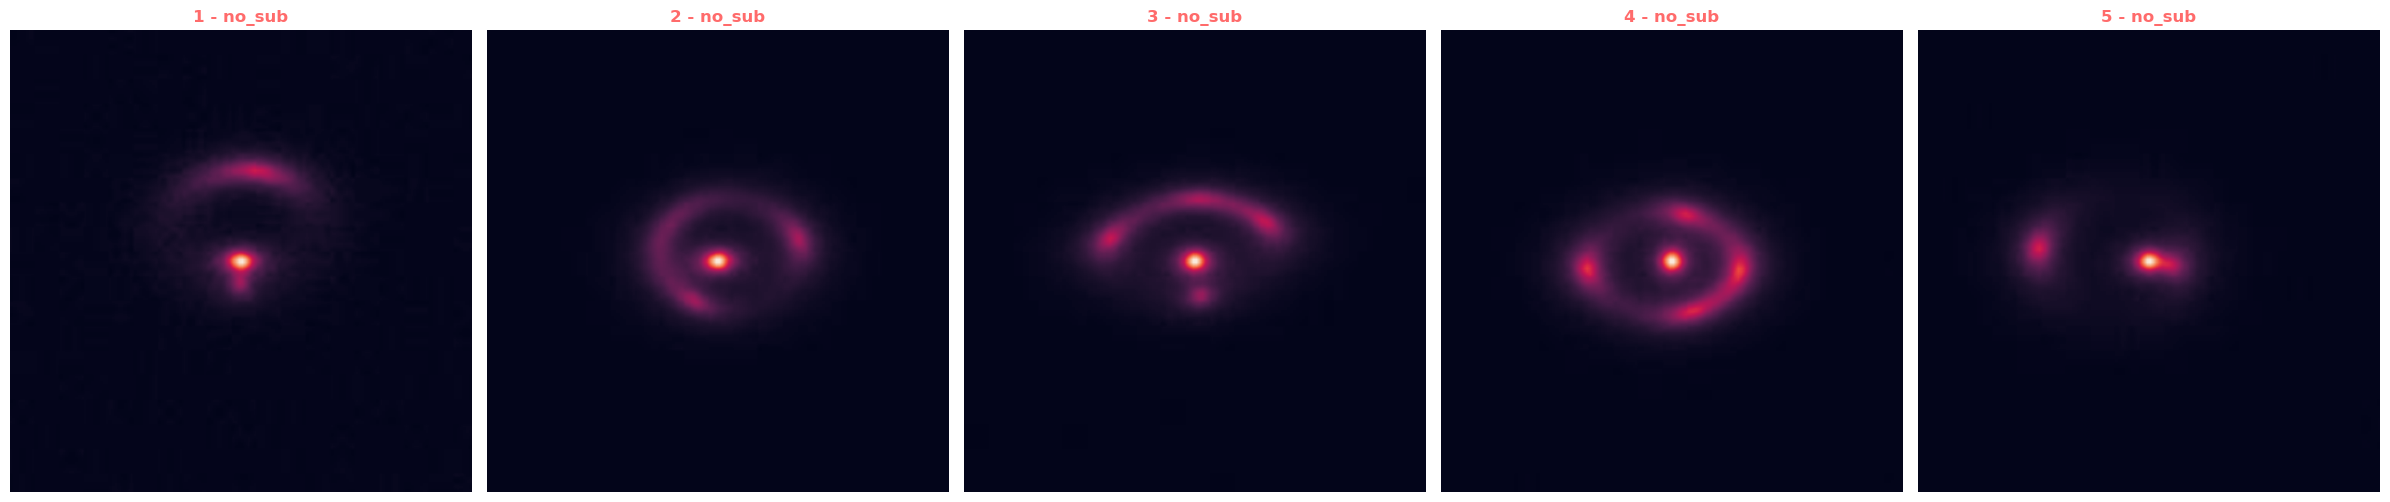

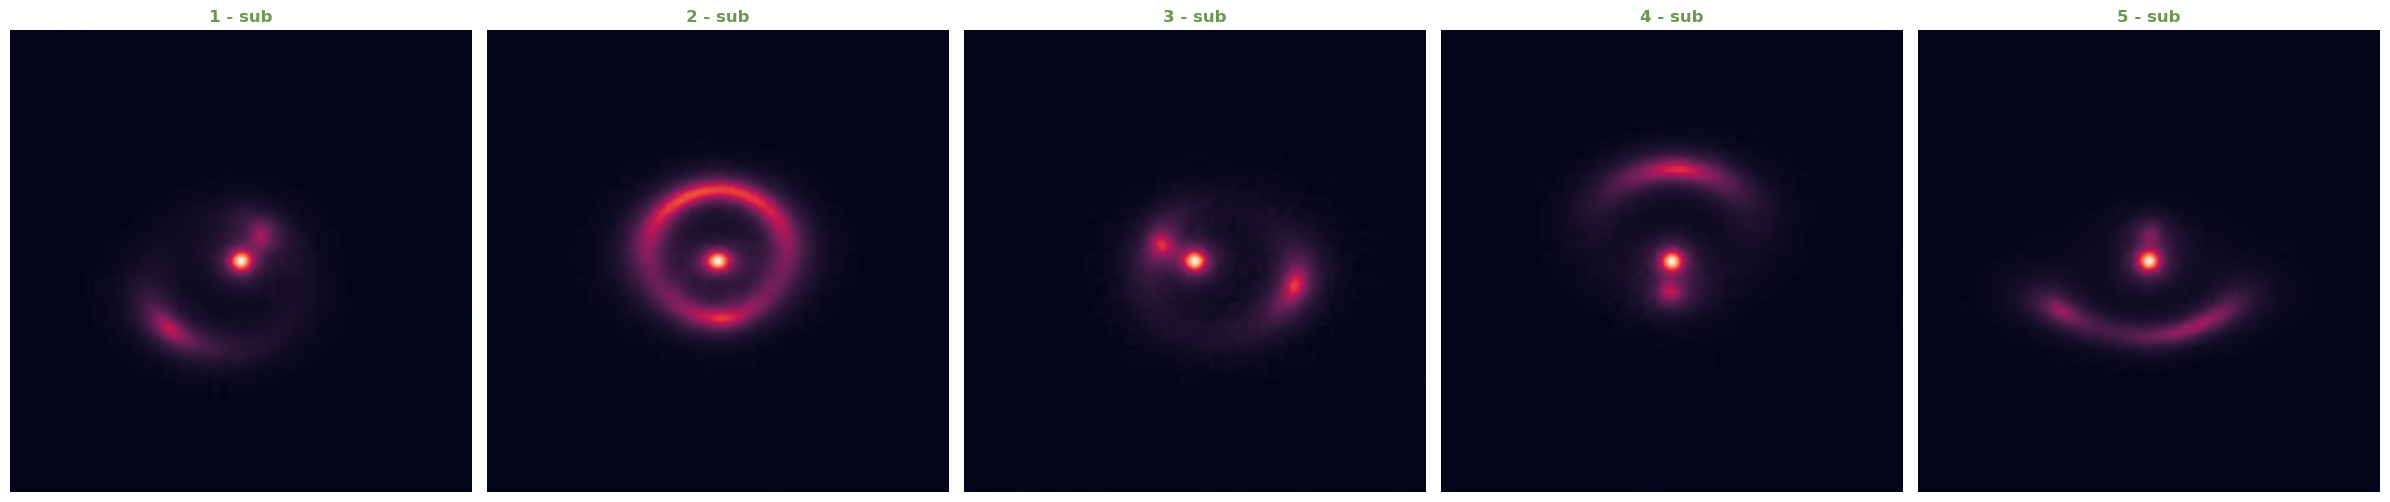

In [8]:
run = wandb.init(project="GSoC23-Task5", name="sample_imgs", config=WANDB_CONFIG)
for target in df['label'].unique():
    view_sample_imgs(df, target)
    
run.finish()

In [9]:
def img_info(data: "pd.DataFrame") -> None:
    """
    This function is a helper function for exploring the image properties.
    
    :param data: the dataframe.
    
    :returns: None
    """
    img_props = defaultdict(lambda: set())
    for img_file in data['img_path'].values:
        img = Image.open(img_file)
        img = np.array(img)
        
        img_props['shape'].add(img.shape)
        img_props['is_rgb'].add(False if len(img.shape) == 2 else True)
        img_props['max_pixel'].add(np.max(img))
        img_props['min_pixel'].add(np.min(img))
        
    table = Table(title="Image Information")
    table.add_column('Properties', justify="right", style="#EE204E", no_wrap=False)
    table.add_column('Values', justify="center", style="#A020F0", no_wrap=False)
    
    for k, v in img_props.items():
        
        if 'max' in k:
            v = max(v)
            table.add_row(k, str(v))
            
        elif 'min' in k:
            v = min(v)
            table.add_row(k, str(v))
        else:   
            table.add_row(k, ", ".join([str(elem) for elem in v]))
        
    console = Console()
    console.print(table)
        

In [10]:
img_info(df)

     Image Information     
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Properties ┃   Values   ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│      shape │ (150, 150) │
│     is_rgb │   False    │
│  max_pixel │    255     │
│  min_pixel │     0      │
└────────────┴────────────┘

# Create DataLoaders

In [11]:
class Normalize255(albumentations.ImageOnlyTransform):
    def apply(self, img, **params):
        return img / 255.

In [12]:
LABELS2IDX = {"no_sub":0, "sub":1}
IDX2LABELS = {v:k for k, v in LABELS2IDX.items()}

class LensDataset(td.Dataset):
    def __init__(self, data: "pd.DataFrame", processor: Any, is_train: bool):
        
        self.data = data
        self.img_processor = processor
        self.is_train = is_train
        
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx: int) -> Dict:
        
        path = self.data.iloc[idx]["img_path"]
        label = self.data.iloc[idx]["label"]
        
        img_mean = self.img_processor.image_mean
        img_std = self.img_processor.image_std
        img_size = (self.img_processor.size["height"], self.img_processor.size["width"])
        
        img = Image.open(path)
        img_arr = np.array(img) # Shape of the image (H, W)
        img_arr = np.expand_dims(img_arr, axis=-1) # Converts shape from (H, W) -> (H, W, 1)
        img_arr = np.concatenate([img_arr, img_arr, img_arr], axis=-1) # Converts (H, W, 1) -> (H, W, 3)
        
        transformations = None
        
        if self.is_train:
            transformations = albumentations.Compose([
                albumentations.RandomBrightnessContrast(),
                albumentations.HorizontalFlip(),
                albumentations.GaussNoise(),
                albumentations.GaussianBlur(),
                albumentations.ShiftScaleRotate(),
                albumentations.OpticalDistortion(),
                albumentations.GridDistortion(),
                albumentations.HueSaturationValue(),
                albumentations.Resize(img_size[0], img_size[1], always_apply=True),
                albumentations.CenterCrop(img_size[0], img_size[1], always_apply=True),
                Normalize255(always_apply=True),
                albumentations.Normalize(mean=img_mean, std=img_std, max_pixel_value=1., always_apply=True)
            ])
            
        else:
            transformations = albumentations.Compose([
                albumentations.Resize(img_size[0], img_size[1], always_apply=True),
                albumentations.CenterCrop(img_size[0], img_size[1], always_apply=True),
                Normalize255(always_apply=True),
                albumentations.Normalize(mean=img_mean, std=img_std, max_pixel_value=1., always_apply=True)
            ])
            
        aug = transformations(image=img_arr)
        img = aug["image"]
        
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)
        
        return {
            "img" : torch.tensor(img, dtype=torch.float),
            "label" : torch.tensor(LABELS2IDX[label], dtype=torch.long)
        }     

In [13]:
class LitLensDataLoader(pl.LightningDataModule):
    def __init__(self, data: "pd.DataFrame", processor: Any, batch_sz: Optional[int]=64):
        
        self.data = data
        self.img_processor = processor
        self.batch_sz = batch_sz
        
        self.dataset = None
        
    def setup(self, stage: Optional[str]=None):
        
        if stage not in ["train", "val", "test"]:
            raise Exception(f"Expected stage to be either train/val/test. Found {stage}")
            
        if stage == "train":
            self.dataset = LensDataset(self.data, self.img_processor, is_train=True)
            
        elif stage == "val":
            self.dataset = LensDataset(self.data, self.img_processor, is_train=False)
            
        else:
            self.dataset = LensDataset(self.data, self.img_processor, is_train=False)
            
    def train_dataloader(self) -> "td.DataLoader":
        return td.DataLoader(self.dataset, batch_size=self.batch_sz, shuffle=True, num_workers=4, pin_memory=True)
    
    def val_dataloader(self) -> "td.DataLoader":
        return td.DataLoader(self.dataset, batch_size=self.batch_sz, shuffle=False, num_workers=4, pin_memory=True)
    
    def test_dataloader(self) -> "td.DataLoader":
        return td.DataLoader(self.dataset, batch_size=self.batch_sz, shuffle=False, num_workers=4, pin_memory=True)        

In [14]:
rprint(f"[bold #ff6b6b]Original Data Shape: [/bold #ff6b6b] {df.shape}")

img_processor = transformers.ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

df_train, df_test = train_test_split(df, test_size=.1, random_state=42, shuffle=True, stratify=df['label'])
df_val, df_test = train_test_split(df_test, test_size=.5, random_state=42, stratify=df_test["label"])

print_dataset(df_train, title="Training Dataset", rule=True)
print_dataset(df_val, title="Validation Dataset", rule=True)
print_dataset(df_test, title="Testing Dataset", rule=True)

Original Data Shape:  (10000, 2)

──────────────────────────────────────────────── Training Dataset ─────────────────────────────────────────────────

                                  Training Dataset                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃                                                                img_path ┃ label  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│    ../data/lenses/sub/image_335359046760425043615970833861398601925.jpg │  sub   │
│    ../data/lenses/sub/image_220174321083528904480269416278019962311.jpg │  sub   │
│ ../data/lenses/no_sub/image_293190990341850053042047254494449637388.jpg │ no_sub │
│    ../data/lenses/sub/image_132958126168414642239985245140213375856.jpg │  sub   │
│ ../data/lenses/no_sub/image_309664260293612340676945115390253221090.jpg │ no_sub │
└─────────────────────────────────────────────────────────────────────────┴────────┘
          The following table originally has 9000 records and 2 attributes          

─────────────────────────────────────────────── Validation Dataset ────────────────────────────────────────────────

                                 Validation Dataset                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃                                                                img_path ┃ label  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ ../data/lenses/no_sub/image_310386929746854442450715920827190014279.jpg │ no_sub │
│     ../data/lenses/sub/image_38884301333140437000009438711228325830.jpg │  sub   │
│ ../data/lenses/no_sub/image_173035371443163008464350441396440251630.jpg │ no_sub │
│      ../data/lenses/sub/image_4334936195908886449921000145954608863.jpg │  sub   │
│       ../data/lenses/sub/image_385388567614913795248549618097249414.jpg │  sub   │
└─────────────────────────────────────────────────────────────────────────┴────────┘
          The following table originally has 500 records and 2 attributes           

───────────────────────────────────────────────── Testing Dataset ─────────────────────────────────────────────────

                                  Testing Dataset                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃                                                                img_path ┃ label  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ ../data/lenses/no_sub/image_113814540229641445614361052374619929269.jpg │ no_sub │
│    ../data/lenses/sub/image_171640028915331998867062599361216484117.jpg │  sub   │
│    ../data/lenses/sub/image_300577186539581823264231645042124386381.jpg │  sub   │
│ ../data/lenses/no_sub/image_253978730274685329302533612422545616920.jpg │ no_sub │
│      ../data/lenses/sub/image_5645153177526790545078202957303267892.jpg │  sub   │
└─────────────────────────────────────────────────────────────────────────┴────────┘
          The following table originally has 500 records and 2 attributes           

In [15]:
train_dm = LitLensDataLoader(df_train, img_processor, batch_sz=32)
val_dm = LitLensDataLoader(df_val, img_processor, batch_sz=128)
test_dm = LitLensDataLoader(df_test, img_processor, batch_sz=128)

train_dm.setup(stage="train")
val_dm.setup(stage="val")
test_dm.setup(stage="test")


train_dl = train_dm.train_dataloader()
val_dl = val_dm.val_dataloader()
test_dl = test_dm.test_dataloader()

# Create Model

In [16]:
class LitClassifier(pl.LightningModule):
    def __init__(self, wandb_log: Optional["wandb.Api"]=None, lr: Optional[float]=1e-5, 
                 weight_decay: Optional[float]=1e-6, T_0: Optional[int]=100, eta_min: Optional[float]=1e-6):
        
        super().__init__()
        
        self.model = transformers.ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=1, ignore_mismatched_sizes=True)
        
        self.wandb_log = wandb_log
        self.lr = lr
        self.weight_decay = weight_decay
        self.T_0 = T_0
        self.eta_min = eta_min
        
        self.aucroc = torchmetrics.AUROC(task="binary", num_classes=1)
        self.acc = torchmetrics.Accuracy(task="binary", num_classes=1, average="macro")
        self.f1 = torchmetrics.F1Score(task="binary", num_classes=1, average="macro")
        
        self.train_res = defaultdict(lambda : list())
        self.val_res = defaultdict(lambda : list())
        self.test_res = defaultdict(lambda: list())
        
        
    def forward(self, x: "torch.Tensor"):
        out = self.model(pixel_values=x)
        return out.logits
    
    def compute_loss(self, logits: "torch.Tensor", y: "torch.Tensor"):
        
        y = y.type_as(logits)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        return loss
    
    def compute_metrics(self, logits: "torch.Tensor", y: "torch.Tensor"):
        
        y = y.type_as(logits)
        
        return {
            "acc" : self.acc(F.sigmoid(logits), y),
            "f1" : self.f1(F.sigmoid(logits), y),
            "aucroc" : self.aucroc(F.sigmoid(logits), y)
        }
    
    
    def common_steps(self, batch, batch_idx):
        
        x, y = batch["img"], batch["label"]
        y = y.reshape(-1, 1)
        
        logits = self(x)
        
        loss = self.compute_loss(logits, y)
        metrics = self.compute_metrics(logits, y)
        
        return loss, metrics
    
    def training_step(self, batch, batch_idx):
        
        loss, metrics = self.common_steps(batch, batch_idx)
        
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        self.train_res["loss"].append(loss)
        self.train_res["acc"].append(metrics["acc"])
        self.train_res["f1"].append(metrics["f1"])
        self.train_res["aucroc"].append(metrics["aucroc"])
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        
        loss, metrics = self.common_steps(batch, batch_idx)
        
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        self.val_res["loss"].append(loss)
        self.val_res["acc"].append(metrics["acc"])
        self.val_res["f1"].append(metrics["f1"])
        self.val_res["aucroc"].append(metrics["aucroc"])
        
        return loss
    
    def test_step(self, batch, batch_idx):
        
        loss, metrics = self.common_steps(batch, batch_idx)
        
        self.log("test/loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        self.test_res["loss"].append(loss)
        self.test_res["acc"].append(metrics["acc"])
        self.test_res["f1"].append(metrics["f1"])
        self.test_res["aucroc"].append(metrics["aucroc"])
        
        return loss
    
    def on_train_epoch_end(self):
        
        all_loss = torch.stack(self.train_res["loss"]).mean()
        all_acc = torch.stack(self.train_res["acc"]).mean()
        all_f1 = torch.stack(self.train_res["f1"]).mean()
        all_aucroc = torch.stack(self.train_res["aucroc"]).mean()
        
        
        if self.wandb_log is not None:
            self.wandb_log.log({'train/loss': all_loss})
            self.wandb_log.log({'train/acc':all_acc})
            self.wandb_log.log({'train/f1':all_f1})
            self.wandb_log.log({'train/aucroc':all_aucroc})
            
            
        for k in self.train_res.keys():
            self.train_res[k].clear()
            
    def on_validation_epoch_end(self):
        
        all_loss = torch.stack(self.val_res["loss"]).mean()
        all_acc = torch.stack(self.val_res["acc"]).mean()
        all_f1 = torch.stack(self.val_res["f1"]).mean()
        all_aucroc = torch.stack(self.val_res["aucroc"]).mean()
        
        self.log("val_aucroc", all_aucroc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        if self.wandb_log is not None:
            self.wandb_log.log({'val/loss': all_loss})
            self.wandb_log.log({'val/acc':all_acc})
            self.wandb_log.log({'val/f1':all_f1})
            self.wandb_log.log({'val/aucroc':all_aucroc})
            
                        
        for k in self.val_res.keys():
            self.val_res[k].clear()
            
    def on_test_epoch_end(self):
        
        all_loss = torch.stack(self.test_res["loss"]).mean()
        all_acc = torch.stack(self.test_res["acc"]).mean()
        all_f1 = torch.stack(self.test_res["f1"]).mean()
        all_aucroc = torch.stack(self.test_res["aucroc"]).mean()
        
        self.log("test_acc", all_acc, logger=True)
        self.log("test_f1", all_f1, logger=True)
        self.log("test_aucroc", all_aucroc, logger=True)
        
        for k in self.test_res.keys():
            self.test_res[k].clear()
        
        return {
            "test_acc" : all_acc,
            "test_f1" : all_f1,
            "test_aucroc" : all_aucroc
        }
    
    
    def configure_optimizers(self):
        
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, self.T_0, eta_min=self.eta_min)
        
        return {
            "optimizer" : optimizer,
            "lr_scheduler" : scheduler
        }
        
        
        
        

In [17]:
run = wandb.init(project="GSoC23-Task5", name="ViT-google_224", config=WANDB_CONFIG)

torch.cuda.empty_cache()
if not os.path.exists("./checkpoints"):
    os.mkdir("./checkpoints")

early_stop = pl.callbacks.EarlyStopping(monitor="val_aucroc", mode="max", patience=3, verbose=True)
model_checkpt = pl.callbacks.ModelCheckpoint(dirpath="./checkpoints", 
                                             filename="best_vit_checkpoint", 
                                             monitor="val_aucroc", 
                                             mode="max", save_top_k=1, save_on_train_epoch_end=False)

prog_bar = pl.callbacks.RichProgressBar()

trainer = pl.Trainer(accelerator="gpu", 
                     devices=1, 
                     precision=16, 
                     max_epochs=100000, 
                     callbacks=[early_stop, model_checkpt, prog_bar])


model = LitClassifier(wandb_log=run)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)
run.finish()

/home/darthvader/miniconda3/envs/mlenv/lib/python3.10/site-packages/lightning/fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/darthvader/minico

┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name   ┃ Type                      ┃ Params ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model  │ ViTForImageClassification │ 85.8 M │
│ 1 │ aucroc │ BinaryAUROC               │      0 │
│ 2 │ acc    │ BinaryAccuracy            │      0 │
│ 3 │ f1     │ BinaryF1Score             │      0 │
└───┴────────┴───────────────────────────┴────────┘

Trainable params: 85.8 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 85.8 M                                                                                               
Total estimated model params size (MB): 343

Output()

Metric val_aucroc improved. New best score: 0.957
Metric val_aucroc improved by 0.015 >= min_delta = 0.0. New best score: 0.972
Metric val_aucroc improved by 0.012 >= min_delta = 0.0. New best score: 0.983
Metric val_aucroc improved by 0.003 >= min_delta = 0.0. New best score: 0.986
Metric val_aucroc improved by 0.001 >= min_delta = 0.0. New best score: 0.988
Metric val_aucroc improved by 0.004 >= min_delta = 0.0. New best score: 0.992
Metric val_aucroc improved by 0.003 >= min_delta = 0.0. New best score: 0.995
Metric val_aucroc improved by 0.002 >= min_delta = 0.0. New best score: 0.996
Metric val_aucroc improved by 0.001 >= min_delta = 0.0. New best score: 0.998
Monitored metric val_aucroc did not improve in the last 3 records. Best score: 0.998. Signaling Trainer to stop.


train/acc,▁▄▅▆▆▇▇█▇████
train/aucroc,▁▅▆▇▇▇▇██████
train/f1,▁▄▅▆▆▇▇█▇████
train/loss,█▆▄▃▃▃▂▂▂▂▁▁▁
val/acc,▁▆▆▇▇▇██▇█████
val/aucroc,▁▇████████████
val/f1,▁▆▅▇▆▇██▇▇▇███
val/loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁
train/acc,0.84951
train/aucroc,0.94124
train/f1,0.84438


# Model Testing

In [18]:
trained_model = LitClassifier.load_from_checkpoint("./checkpoints/best_vit_checkpoint-v4.ckpt")
trained_model.freeze()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
new_trainer = pl.Trainer(accelerator="gpu", devices=1, precision=16, callbacks=[pl.callbacks.RichProgressBar()])
test_res = new_trainer.test(trained_model, dataloaders=test_dl)

if not os.path.exists('./results'):
    os.mkdir("./results")
    
with open("./results/res.json", 'w') as fp:
    json.dump(test_res[0], fp)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │    0.10827668756246567    │
│         test_acc          │    0.9497575759887695     │
│        test_aucroc        │    0.9988211989402771     │
│          test_f1          │     0.947415292263031     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
g